# 1. Neural network with keras

In [1]:
import os
from keras import backend as K

K.backend() # check backend of Keras

Using TensorFlow backend.


'tensorflow'

In [0]:
import numpy as np
from datetime import datetime
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense
from keras.utils import np_utils
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
from keras.optimizers import SGD

sns.set() # Draw grid on plot

In [0]:
"""
 That class, Timer checks elasped time for training
"""
class Timer:

  def __init__(self):
    self.start = None
    self.end = None

  def start_timer(self):
    self.start = datetime.now()

  def stop_timer(self):
    self.end = datetime.now()
    return self.end - self.start

In [0]:
def display_dataset(X_train, y_train):  
  fig, ax = plt.subplots(8, 8, figsize = (6, 6))
  fig.suptitle('MNIST')
  fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
  for y, x in [(j, i) for j in range(8) for i in range(8)]:
    idx = np.random.randint(len(y_test))
    ax[y, x].imshow(X_train[idx])
    ax[y, x].set_title(y_train[idx])
    ax[y,x].axis('off')

def display_history(history):
  h = history.history
  fig, ax = plt.subplots(1,2, figsize = (8,4))
  plt.subplots_adjust(wspace = 0.5)
  fig.suptitle('Training result')

  ax[0].set_title('Accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].plot(h['acc'])
  ax[0].plot(h['val_acc'])
  
  ax[1].set_title('Loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].plot(h['loss'])
  ax[1].plot(h['val_loss'])
  fig.legend(['train','validation'])

def visualize_prediction(X_test,y_test,preds):
  fig, ax = plt.subplots(4, 4, figsize = (10, 10))
  plt.subplots_adjust(hspace = 0.8)
  fig.suptitle('Test')

  for y, x in [(j, i) for j in range(4) for i in range(4)]:
    if y == 2 and x == 0 : # display false prediction
      _X_test = X_test[y_test != preds.argmax(-1)]
      _preds = preds[y_test != preds.argmax(-1)]
      _y_test = y_test[y_test != preds.argmax(-1)]

    elif y == 0 and x == 0 : # display true prediction
      _X_test = X_test[y_test == preds.argmax(-1)]
      _preds = preds[y_test == preds.argmax(-1)]
      _y_test = y_test[y_test == preds.argmax(-1)]
      
      
    idx = np.random.randint(len(_y_test))
    ax[y, x].set_title("true : "+str(_y_test[idx])+"\n pred : " + str(_preds[idx].argmax())+"\n"+str(round(_preds[idx].max(),2)))
    ax[y, x].axis('off')
    ax[y, x].imshow(_X_test[idx])

In [5]:
model = None
CLASSES = 10 # Number of labels
HIDDENS = 128 # How many neurons(nodes) in hidden layers
EPOCHS = 20 # train dataset is used "EPOCHS" times
BATCH_SIZE = 128 # How many data in the train dataset are used for update of weights one time
VERBOSE = 2 # How expression for training is printed
VALIDATION_SPLIT = 0.2 # How many data in train dataset are used for validation dataset which is not used for training

"""
 60,000 number of training dataset
 10,000 number of test dataset
 X_train includes 60,000 number of data, 28x28 matrix, to be trained
 y_train includes one vector whose number of elements is 60,000
 X_test includes 10,000 number of data, 28x28 matrix, to be trained
 y_test includes one vector whose number of elements is 10,000
"""
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# look channel, number of data, is first
print('X_train.shape :',X_train.shape,'It means there are 60,000 number of data, 28x28 matrix in train dataset')
print('X_test.shape :',X_test.shape,' It means there are 10,000 number of data, 28x28 matrix in test dataset')

X_train.shape : (60000, 28, 28) It means there are 60,000 number of data, 28x28 matrix in train dataset
X_test.shape : (10000, 28, 28)  It means there are 10,000 number of data, 28x28 matrix in test dataset


In [6]:
print('y_train.shape :',y_train.shape,'It means that y_train includes one vector whose number of elements is 60,000')
print('y_test,shape :',y_test.shape,'It means that y_test includes one vector whose number of elements is 10,000')

y_train.shape : (60000,) It means that y_train includes one vector whose number of elements is 60,000
y_test,shape : (10000,) It means that y_test includes one vector whose number of elements is 10,000


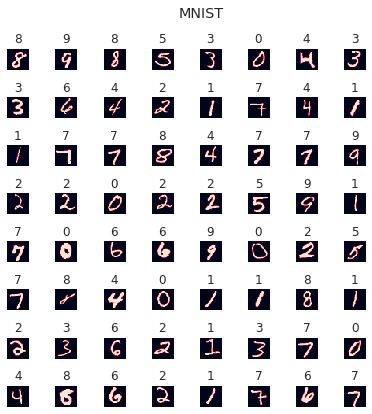

In [7]:
# Visualize dataset
display_dataset(X_train, y_train)

In [8]:
"""
 Every image, 28x28 matrix, for train dataset and test dataset has to be converted into vector to be entered.
 As a result, X_train and X_test become 60,000x784 matrix and 10,000x784 matrix that size of each row means number of data 
and size of each column means number of features, 28*28=784.
 Before being entered into the model, they have to be normalized. 
"""
X_train = X_train.reshape(60000,784).astype('float32')
X_test = X_test.reshape(10000,784).astype('float32')

# Divide each feature by 255, maximum value of brightness, to normalize those data
X_train /= 255
X_test /= 255

"""
 Following is one-hot-encoding.
 As I mentioned, the vector has 60,000 number of elements in y_train 
and 10,000 number of elements in y_test.
 One-hot encoding makes the vector a matrix that size of each row means number of data and size of each column means number of labels.
 Each label is re-written in label-th element as 1 and the others as 0
(e.g. 4 -> [0,0,0,0,1,0,0,0,0,0], remember label is one of 0 ~ 9) 
"""
Y_train = np_utils.to_categorical(y_train, CLASSES)
Y_test = np_utils.to_categorical(y_test, CLASSES)
print('Y_train.shape :',Y_train.shape)
print('Y_test.shape :',Y_test.shape)

Y_train.shape : (60000, 10)
Y_test.shape : (10000, 10)


In [9]:
"""
 Following code is single layer perceptron.
 That class, Dense() means fully connected layer.
 As a result, number of parameters is that 784*10(weights) + 10(biases) = 7850.
 If you run that code, then you see Output Shape is (None, 10). None means batch size, you will define in the method, fit().
and 10 means number of labels 
 A row of Output Shape is None that batch size which will be defined by user later.
"""
if model != None:
  K.clear_session()
model = Sequential()
model.add(Dense(CLASSES, input_shape = (784,),activation = 'softmax'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 48000 samples, validate on 12000 samples
Epoch 1/20





 - 1s - loss: 1.3921 - acc: 0.6588 - val_loss: 0.8994 - val_acc: 0.8257
Epoch 2/20
 - 1s - loss: 0.7981 - acc: 0.8266 - val_loss: 0.6601 - val_acc: 0.8564
Epoch 3/20
 - 1s - loss: 0.6466 - acc: 0.8492 - val_loss: 0.5635 - val_acc: 0.8690
Epoch 4/20
 - 1s - loss: 0.5733 - acc: 0.8604 - val_loss: 0.5100 - val_acc: 0.8768
Epoch 5/20
 - 1s - loss: 0.5288 - acc: 0.8676 - val_loss: 0.4756 - val_acc: 0.8818
Epoch 6/20
 - 1s - loss: 0.4982 - acc: 0.8732 - val_loss: 0.4513 - val_acc: 0.8853
Epoch 7/20
 - 1s - loss: 0.4756 - acc: 0.8769 - val_loss: 0.4330 - val_acc: 0.8880
Epoch 8/20
 - 1s - loss: 0.4580 - acc: 0.8805 - val_loss: 0.4188 - val_acc: 0.8899
Epoch 9/20
 - 1s - loss: 0.4439 - acc: 0.8832 - val_loss: 0.4069 - val_acc: 0.8937
Epoch 10/20
 - 1s - loss: 0.4322 - acc: 0.8853 - val_loss: 0.3975 - val_acc: 0.8952
Epoch 11/20
 - 

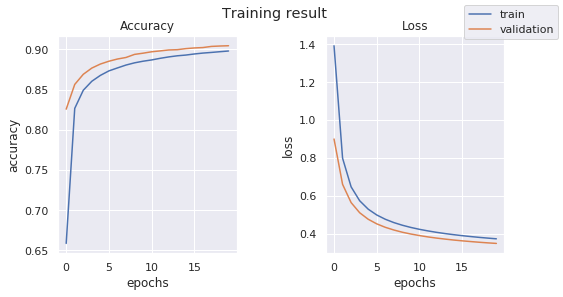

In [11]:
display_history(history)

In [12]:
_, accuracy = model.evaluate(X_test, Y_test)
print('Accuracy :',accuracy)

10000/10000 [==============================] - 0s 22us/step
Accuracy : 0.9041


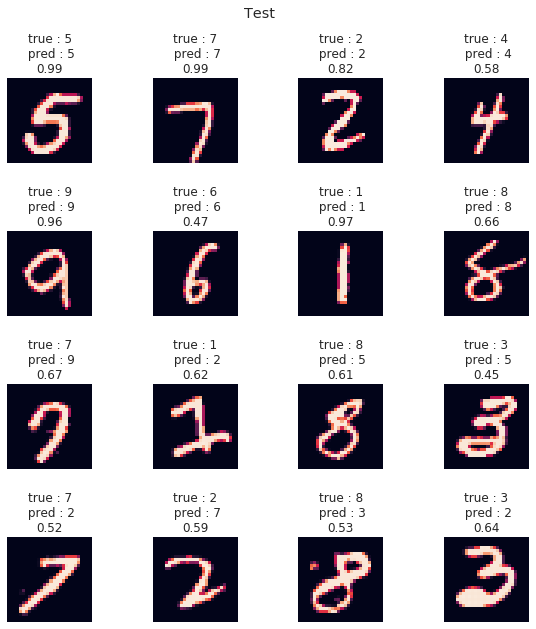

In [13]:
preds = model.predict(X_test)
visualize_prediction(X_test.reshape(10000,28,28),y_test,preds)

## MLP
- 2 layers
- 3 layers
- 4 layers
- 20 layers

In [0]:
"""
 That method describes how many layers are created, using that parameter, layers.
 The number of neurons is same in all layers, except for last layer.
"""
def create_mlp(layers):
  model = Sequential()
  model.add(Dense(HIDDENS, input_shape = (784,), activation = 'relu'))
  if layers > 2:
    for i in range(layers - 2):
      model.add(Dense(HIDDENS, activation = 'relu'))
  model.add(Dense(CLASSES, activation = 'softmax'))
  return model

In [15]:
if model != None:
  K.clear_session()
model = create_mlp(2)
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.2500 - acc: 0.6865 - val_loss: 0.7087 - val_acc: 0.8434
Epoch 2/20
 - 1s - loss: 0.6147 - acc: 0.8496 - val_loss: 0.4904 - val_acc: 0.8787
Epoch 3/20
 - 2s - loss: 0.4811 - acc: 0.8750 - val_loss: 0.4143 - val_acc: 0.8916
Epoch 4/20
 - 1s - loss: 0.4216 - acc: 0.8867 - val_loss: 0.3741 - val_acc: 0.9016
Epoch 5/20
 - 1s - loss: 0.3866 - acc: 0.8943 - val_loss: 0.3485 - val_acc: 0.9057
Epoch 6/20
 - 2s - loss: 0.3624 - acc: 0.9007 - val_loss: 0.3310 - val_acc: 0.9090
Epoch 7/20
 - 2s - loss: 0.3447 - acc: 0.9050 - val_loss: 0.3170 - val_acc: 0.9136
Epoch 8/20
 - 1s - loss: 0.3304 - acc: 0.9082 - val_loss: 0.3054 - val_acc: 0.9138
Epoch 9/20
 - 1s - loss: 0.3184 - acc: 0.9112 - val_loss: 0.2966 - val_acc: 0.9172
Epoch 10/20
 - 2s - loss: 0.3082 - acc: 0.9143 - val_loss: 0.2882 - val_acc: 0.9186
Epoch 11/20
 - 2s - loss: 0.2992 - acc: 0.9162 - val_loss: 0.2806 - val_acc: 0.9210
Epoch 12/20
 - 2s - loss: 0.2911 - 

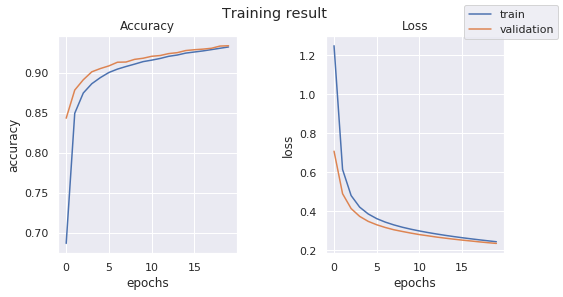

In [17]:
display_history(history = history)

In [18]:
_, accuracy = model.evaluate(X_test, Y_test)
print('Accuracy :',accuracy)

10000/10000 [==============================] - 0s 29us/step
Accuracy : 0.9325


In [19]:
if model != None:
  K.clear_session()
model = create_mlp(3)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.4590 - acc: 0.6348 - val_loss: 0.7385 - val_acc: 0.8376
Epoch 2/20
 - 2s - loss: 0.5890 - acc: 0.8539 - val_loss: 0.4476 - val_acc: 0.8858
Epoch 3/20
 - 2s - loss: 0.4319 - acc: 0.8835 - val_loss: 0.3684 - val_acc: 0.8997
Epoch 4/20
 - 2s - loss: 0.3735 - acc: 0.8963 - val_loss: 0.3316 - val_acc: 0.9081
Epoch 5/20
 - 2s - loss: 0.3409 - acc: 0.9046 - val_loss: 0.3076 - val_acc: 0.9129
Epoch 6/20
 - 2s - loss: 0.3186 - acc: 0.9100 - val_loss: 0.2908 - val_acc: 0.9170
Epoch 7/20
 - 2s - loss: 0.3014 - acc: 0.9146 - val_loss: 0.2785 - val_acc: 0.9208
Epoch 8/20
 - 2s - loss: 0.2879 - acc: 0.9183 - val_loss: 0.2674 - val_acc: 0.9249
Epoch 9/20
 - 2s - loss: 0.2761 - acc: 0.9223 - val_loss: 0.2583 - val_acc: 0.9269
Epoch 10/20
 - 2s - loss: 0.2657 - acc: 0.9242 - val_loss: 0.2497 - val_acc: 0.9296
Epoch 11/20
 - 2s - loss: 0.2561 - acc: 0.9269 - val_loss: 0.2419 - val_acc: 0.9315
Epoch 12/20
 - 2s - loss: 0.2476 - 

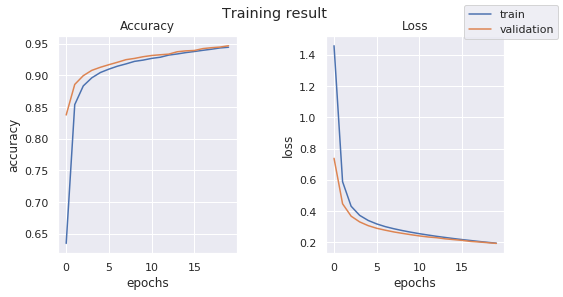

In [21]:
display_history(history = history)

In [22]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :',acc)

Accuracy : 0.945


In [23]:
if model != None:
  K.clear_session()
model = create_mlp(4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.5213 - acc: 0.6036 - val_loss: 0.7382 - val_acc: 0.8156
Epoch 2/20
 - 2s - loss: 0.5839 - acc: 0.8418 - val_loss: 0.4396 - val_acc: 0.8807
Epoch 3/20
 - 2s - loss: 0.4216 - acc: 0.8803 - val_loss: 0.3576 - val_acc: 0.8997
Epoch 4/20
 - 2s - loss: 0.3591 - acc: 0.8977 - val_loss: 0.3169 - val_acc: 0.9087
Epoch 5/20
 - 2s - loss: 0.3221 - acc: 0.9077 - val_loss: 0.2916 - val_acc: 0.9162
Epoch 6/20
 - 2s - loss: 0.2950 - acc: 0.9148 - val_loss: 0.2712 - val_acc: 0.9223
Epoch 7/20
 - 2s - loss: 0.2747 - acc: 0.9204 - val_loss: 0.2588 - val_acc: 0.9269
Epoch 8/20
 - 2s - loss: 0.2572 - acc: 0.9264 - val_loss: 0.2382 - val_acc: 0.9322
Epoch 9/20
 - 2s - loss: 0.2421 - acc: 0.9301 - val_loss: 0.2279 - val_acc: 0.9351
Epoch 10/20
 - 2s - loss: 0.2293 - acc: 0.9337 - val_loss: 0.2161 - val_acc: 0.9382
Epoch 11/20
 - 2s - loss: 0.2181 - acc: 0.9369 - val_loss: 0.2081 - val_acc: 0.9416
Epoch 12/20
 - 2s - loss: 0.2069 - 

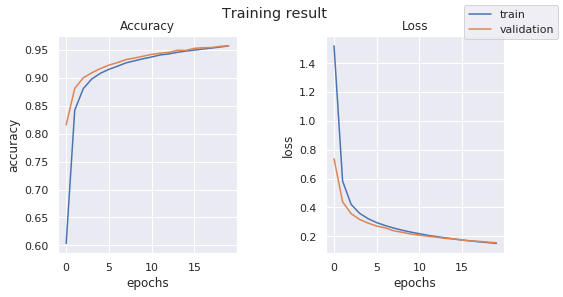

In [25]:
display_history(history = history)

In [26]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9551


In [27]:
if model != None:
  K.clear_session()
model = create_mlp(20)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [28]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 4s - loss: 2.3015 - acc: 0.1141 - val_loss: 2.3014 - val_acc: 0.1060
Epoch 2/20
 - 4s - loss: 2.2999 - acc: 0.1140 - val_loss: 2.2999 - val_acc: 0.1060
Epoch 3/20
 - 4s - loss: 2.2971 - acc: 0.1140 - val_loss: 2.2956 - val_acc: 0.1060
Epoch 4/20
 - 4s - loss: 2.2883 - acc: 0.1140 - val_loss: 2.2803 - val_acc: 0.1060
Epoch 5/20
 - 4s - loss: 2.2515 - acc: 0.1907 - val_loss: 2.2058 - val_acc: 0.2698
Epoch 6/20
 - 4s - loss: 2.0325 - acc: 0.3001 - val_loss: 1.7802 - val_acc: 0.3478
Epoch 7/20
 - 4s - loss: 1.4114 - acc: 0.4334 - val_loss: 1.4976 - val_acc: 0.3912
Epoch 8/20
 - 4s - loss: 1.0600 - acc: 0.5952 - val_loss: 0.7562 - val_acc: 0.7284
Epoch 9/20
 - 4s - loss: 0.8090 - acc: 0.7261 - val_loss: 0.7530 - val_acc: 0.7208
Epoch 10/20
 - 4s - loss: 0.5805 - acc: 0.8233 - val_loss: 0.4826 - val_acc: 0.8518
Epoch 11/20
 - 4s - loss: 0.4521 - acc: 0.8747 - val_loss: 1.0934 - val_acc: 0.6552
Epoch 12/20
 - 4s - loss: 0.3760 - 

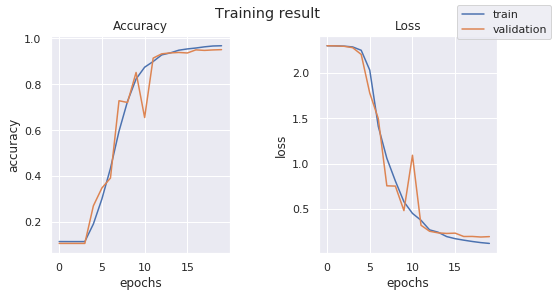

In [29]:
display_history(history = history)

In [30]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9511


## Weight initializer
- he_uniform
- he_normal
- glorot_normal   
cf) The default initializer is glorot_uniform, so it's not measured

In [0]:
def create_mlp(layers, initializer):
  model = Sequential()
  model.add(Dense(HIDDENS, input_shape = (784,), activation = 'relu', kernel_initializer = initializer))
  if layers > 2:
    for i in range(layers - 2):
      model.add(Dense(HIDDENS, activation = 'relu',kernel_initializer=initializer))
  model.add(Dense(CLASSES, activation = 'softmax', kernel_initializer = initializer))
  return model

In [32]:
if model != None:
  K.clear_session()
model = create_mlp(4, 'he_uniform')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.0989 - acc: 0.7075 - val_loss: 0.4953 - val_acc: 0.8714
Epoch 2/20
 - 2s - loss: 0.4369 - acc: 0.8796 - val_loss: 0.3462 - val_acc: 0.9023
Epoch 3/20
 - 2s - loss: 0.3466 - acc: 0.9020 - val_loss: 0.2997 - val_acc: 0.9125
Epoch 4/20
 - 2s - loss: 0.3051 - acc: 0.9125 - val_loss: 0.2728 - val_acc: 0.9223
Epoch 5/20
 - 2s - loss: 0.2771 - acc: 0.9210 - val_loss: 0.2531 - val_acc: 0.9259
Epoch 6/20
 - 2s - loss: 0.2565 - acc: 0.9262 - val_loss: 0.2373 - val_acc: 0.9324
Epoch 7/20
 - 2s - loss: 0.2391 - acc: 0.9314 - val_loss: 0.2225 - val_acc: 0.9368
Epoch 8/20
 - 2s - loss: 0.2247 - acc: 0.9353 - val_loss: 0.2123 - val_acc: 0.9407
Epoch 9/20
 - 2s - loss: 0.2117 - acc: 0.9395 - val_loss: 0.2002 - val_acc: 0.9447
Epoch 10/20
 - 2s - loss: 0.2008 - acc: 0.9423 - val_loss: 0.1967 - val_acc: 0.9440
Epoch 11/20
 - 2s - loss: 0.1908 - acc: 0.9451 - val_loss: 0.1874 - val_acc: 0.9483
Epoch 12/20
 - 2s - loss: 0.1814 - 

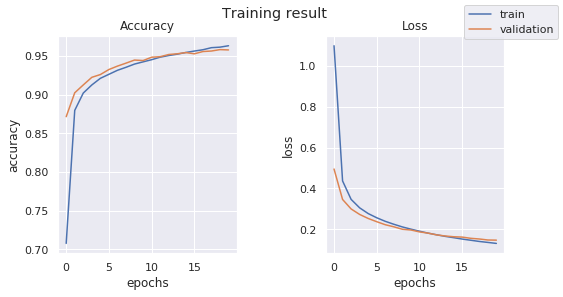

In [34]:
display_history(history = history)

In [35]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9569


In [36]:
if model != None:
  K.clear_session()
model = create_mlp(4,'he_normal')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.1244 - acc: 0.6932 - val_loss: 0.5014 - val_acc: 0.8740
Epoch 2/20
 - 2s - loss: 0.4369 - acc: 0.8798 - val_loss: 0.3471 - val_acc: 0.9035
Epoch 3/20
 - 2s - loss: 0.3413 - acc: 0.9028 - val_loss: 0.2952 - val_acc: 0.9153
Epoch 4/20
 - 2s - loss: 0.2992 - acc: 0.9135 - val_loss: 0.2666 - val_acc: 0.9230
Epoch 5/20
 - 2s - loss: 0.2712 - acc: 0.9216 - val_loss: 0.2478 - val_acc: 0.9284
Epoch 6/20
 - 2s - loss: 0.2495 - acc: 0.9269 - val_loss: 0.2288 - val_acc: 0.9342
Epoch 7/20
 - 2s - loss: 0.2325 - acc: 0.9322 - val_loss: 0.2193 - val_acc: 0.9382
Epoch 8/20
 - 2s - loss: 0.2173 - acc: 0.9361 - val_loss: 0.2057 - val_acc: 0.9416
Epoch 9/20
 - 2s - loss: 0.2039 - acc: 0.9399 - val_loss: 0.1944 - val_acc: 0.9452
Epoch 10/20
 - 2s - loss: 0.1929 - acc: 0.9436 - val_loss: 0.1870 - val_acc: 0.9462
Epoch 11/20
 - 2s - loss: 0.1821 - acc: 0.9467 - val_loss: 0.1779 - val_acc: 0.9495
Epoch 12/20
 - 2s - loss: 0.1730 - 

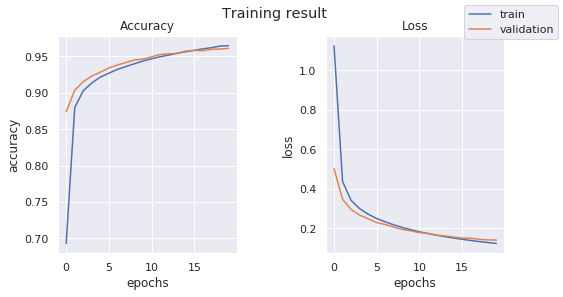

In [38]:
display_history(history = history)

In [39]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.96


In [40]:
if model != None:
  K.clear_session()
model = create_mlp(4, 'glorot_normal')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.6108 - acc: 0.5723 - val_loss: 0.7645 - val_acc: 0.8233
Epoch 2/20
 - 2s - loss: 0.5751 - acc: 0.8481 - val_loss: 0.4252 - val_acc: 0.8825
Epoch 3/20
 - 2s - loss: 0.4091 - acc: 0.8850 - val_loss: 0.3505 - val_acc: 0.8997
Epoch 4/20
 - 2s - loss: 0.3499 - acc: 0.8998 - val_loss: 0.3136 - val_acc: 0.9091
Epoch 5/20
 - 2s - loss: 0.3155 - acc: 0.9092 - val_loss: 0.2842 - val_acc: 0.9171
Epoch 6/20
 - 2s - loss: 0.2919 - acc: 0.9158 - val_loss: 0.2654 - val_acc: 0.9240
Epoch 7/20
 - 2s - loss: 0.2733 - acc: 0.9213 - val_loss: 0.2517 - val_acc: 0.9288
Epoch 8/20
 - 2s - loss: 0.2575 - acc: 0.9253 - val_loss: 0.2349 - val_acc: 0.9329
Epoch 9/20
 - 2s - loss: 0.2438 - acc: 0.9290 - val_loss: 0.2255 - val_acc: 0.9366
Epoch 10/20
 - 2s - loss: 0.2315 - acc: 0.9332 - val_loss: 0.2152 - val_acc: 0.9384
Epoch 11/20
 - 2s - loss: 0.2205 - acc: 0.9358 - val_loss: 0.2066 - val_acc: 0.9409
Epoch 12/20
 - 2s - loss: 0.2106 - 

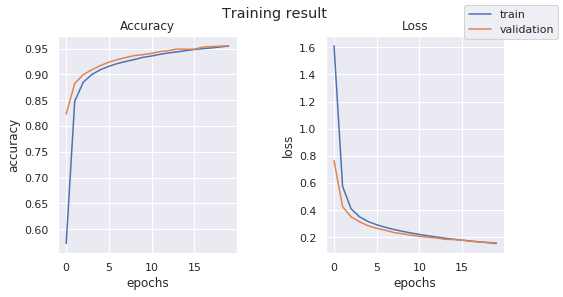

In [42]:
display_history(history = history)

In [43]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9531


## Optimizer
- rmsprop
- adam  
cf) sgd is already measured.

In [44]:
if model != None:
  K.clear_session()
model = create_mlp(4,'glorot_normal')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 0.3566 - acc: 0.8926 - val_loss: 0.1630 - val_acc: 0.9533
Epoch 2/20
 - 2s - loss: 0.1497 - acc: 0.9548 - val_loss: 0.1161 - val_acc: 0.9663
Epoch 3/20
 - 2s - loss: 0.1043 - acc: 0.9672 - val_loss: 0.1152 - val_acc: 0.9657
Epoch 4/20
 - 2s - loss: 0.0806 - acc: 0.9755 - val_loss: 0.1013 - val_acc: 0.9720
Epoch 5/20
 - 2s - loss: 0.0643 - acc: 0.9799 - val_loss: 0.1025 - val_acc: 0.9716
Epoch 6/20
 - 2s - loss: 0.0519 - acc: 0.9833 - val_loss: 0.0991 - val_acc: 0.9737
Epoch 7/20
 - 2s - loss: 0.0447 - acc: 0.9864 - val_loss: 0.1061 - val_acc: 0.9733
Epoch 8/20
 - 2s - loss: 0.0396 - acc: 0.9872 - val_loss: 0.0985 - val_acc: 0.9768
Epoch 9/20
 - 2s - loss: 0.0315 - acc: 0.9904 - val_loss: 0.1148 - val_acc: 0.9740
Epoch 10/20
 - 2s - loss: 0.0286 - acc: 0.9915 - val_loss: 0.1142 - val_acc: 0.9739
Epoch 11/20
 - 2s - loss: 0.0261 - acc: 0.9917 - val_loss: 0.1115 - val_acc: 0.9783
Epoch 12/20
 - 2s - loss: 0.0217 - 

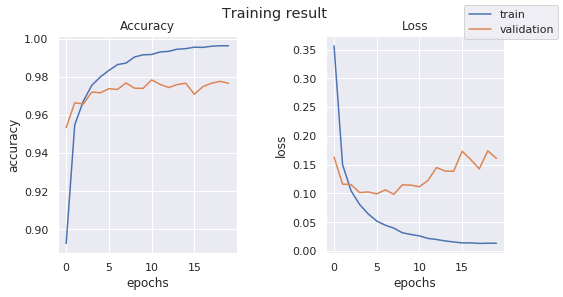

In [46]:
display_history(history = history)

In [47]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9783


In [48]:
if model != None:
  K.clear_session()
model = create_mlp(4,'glorot_normal')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 3s - loss: 0.3352 - acc: 0.9035 - val_loss: 0.1696 - val_acc: 0.9490
Epoch 2/20
 - 2s - loss: 0.1292 - acc: 0.9611 - val_loss: 0.1158 - val_acc: 0.9648
Epoch 3/20
 - 2s - loss: 0.0860 - acc: 0.9742 - val_loss: 0.1109 - val_acc: 0.9667
Epoch 4/20
 - 2s - loss: 0.0646 - acc: 0.9799 - val_loss: 0.1006 - val_acc: 0.9717
Epoch 5/20
 - 2s - loss: 0.0546 - acc: 0.9829 - val_loss: 0.0944 - val_acc: 0.9721
Epoch 6/20
 - 2s - loss: 0.0409 - acc: 0.9870 - val_loss: 0.1001 - val_acc: 0.9726
Epoch 7/20
 - 2s - loss: 0.0316 - acc: 0.9897 - val_loss: 0.0939 - val_acc: 0.9741
Epoch 8/20
 - 2s - loss: 0.0253 - acc: 0.9917 - val_loss: 0.1184 - val_acc: 0.9697
Epoch 9/20
 - 2s - loss: 0.0226 - acc: 0.9928 - val_loss: 0.1001 - val_acc: 0.9746
Epoch 10/20
 - 2s - loss: 0.0214 - acc: 0.9929 - val_loss: 0.1064 - val_acc: 0.9759
Epoch 11/20
 - 2s - loss: 0.0214 - acc: 0.9930 - val_loss: 0.1140 - val_acc: 0.9727
Epoch 12/20
 - 2s - loss: 0.0147 - 

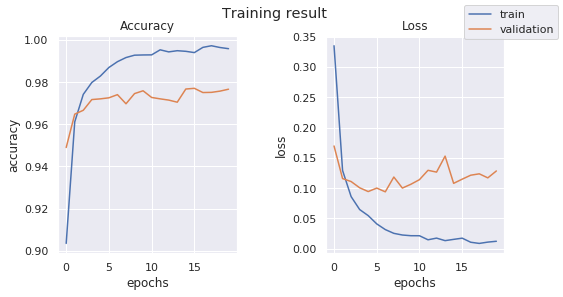

In [50]:
display_history(history = history)

In [51]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9779


In [0]:
from keras.regularizers import l2

def create_mlp(layers, initializer):

  model = Sequential()
  model.add(Dense(HIDDENS, input_shape = (784,), activation = 'relu', kernel_initializer = initializer,kernel_regularizer=l2(0.01)))
  if layers > 2:
    for i in range(layers - 2):
      model.add(Dense(HIDDENS, activation = 'relu',kernel_initializer=initializer))
  model.add(Dense(CLASSES, activation = 'softmax', kernel_initializer = initializer))
  return model

In [53]:
if model != None:
  K.clear_session()
model = create_mlp(4, 'glorot_normal')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 3s - loss: 0.7771 - acc: 0.8928 - val_loss: 0.3142 - val_acc: 0.9462
Epoch 2/20
 - 2s - loss: 0.2845 - acc: 0.9465 - val_loss: 0.2494 - val_acc: 0.9553
Epoch 3/20
 - 2s - loss: 0.2407 - acc: 0.9548 - val_loss: 0.2671 - val_acc: 0.9461
Epoch 4/20
 - 2s - loss: 0.2212 - acc: 0.9594 - val_loss: 0.2199 - val_acc: 0.9615
Epoch 5/20
 - 2s - loss: 0.2057 - acc: 0.9634 - val_loss: 0.2238 - val_acc: 0.9577
Epoch 6/20
 - 2s - loss: 0.1991 - acc: 0.9656 - val_loss: 0.2081 - val_acc: 0.9627
Epoch 7/20
 - 2s - loss: 0.1898 - acc: 0.9679 - val_loss: 0.1954 - val_acc: 0.9654
Epoch 8/20
 - 2s - loss: 0.1874 - acc: 0.9665 - val_loss: 0.1940 - val_acc: 0.9688
Epoch 9/20
 - 2s - loss: 0.1791 - acc: 0.9690 - val_loss: 0.1898 - val_acc: 0.9666
Epoch 10/20
 - 2s - loss: 0.1747 - acc: 0.9706 - val_loss: 0.1788 - val_acc: 0.9710
Epoch 11/20
 - 2s - loss: 0.1735 - acc: 0.9704 - val_loss: 0.1932 - val_acc: 0.9667
Epoch 12/20
 - 2s - loss: 0.1674 - 

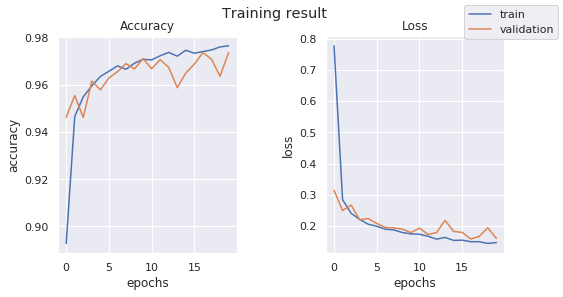

In [55]:
display_history(history = history)

In [56]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9739


## Regularization
- L2
- Dropout
- Batch normalization

In [0]:
from keras.regularizers import l2

def create_mlp(layers, initializer):

  model = Sequential()
  model.add(Dense(HIDDENS, input_shape = (784,), activation = 'relu', kernel_initializer = initializer, kernel_regularizer = l2(0.01)))
  if layers > 2:
    for i in range(layers - 2):
      model.add(Dense(HIDDENS, activation = 'relu',kernel_initializer=initializer))
  model.add(Dense(CLASSES, activation = 'softmax', kernel_initializer = initializer))
  return model

In [58]:
if model != None:
  K.clear_session()
model = create_mlp(4,'glorot_normal')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 3s - loss: 0.7857 - acc: 0.8914 - val_loss: 0.3135 - val_acc: 0.9489
Epoch 2/20
 - 2s - loss: 0.2798 - acc: 0.9482 - val_loss: 0.2389 - val_acc: 0.9579
Epoch 3/20
 - 2s - loss: 0.2407 - acc: 0.9553 - val_loss: 0.2311 - val_acc: 0.9597
Epoch 4/20
 - 2s - loss: 0.2185 - acc: 0.9610 - val_loss: 0.2292 - val_acc: 0.9553
Epoch 5/20
 - 2s - loss: 0.2128 - acc: 0.9619 - val_loss: 0.2118 - val_acc: 0.9619
Epoch 6/20
 - 2s - loss: 0.1994 - acc: 0.9652 - val_loss: 0.2103 - val_acc: 0.9632
Epoch 7/20
 - 2s - loss: 0.1919 - acc: 0.9666 - val_loss: 0.2076 - val_acc: 0.9622
Epoch 8/20
 - 2s - loss: 0.1832 - acc: 0.9686 - val_loss: 0.1937 - val_acc: 0.9658
Epoch 9/20
 - 2s - loss: 0.1816 - acc: 0.9690 - val_loss: 0.1871 - val_acc: 0.9685
Epoch 10/20
 - 2s - loss: 0.1747 - acc: 0.9704 - val_loss: 0.1907 - val_acc: 0.9681
Epoch 11/20
 - 2s - loss: 0.1735 - acc: 0.9700 - val_loss: 0.1928 - val_acc: 0.9658
Epoch 12/20
 - 2s - loss: 0.1690 - 

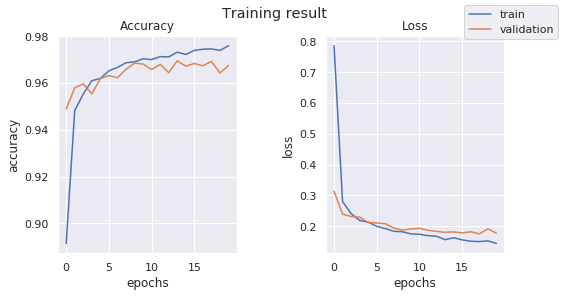

In [60]:
display_history(history = history)

In [61]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9705


In [0]:
from keras.layers.core import Dropout

def create_mlp(layers, initializer):

  model = Sequential()
  model.add(Dense(HIDDENS, input_shape = (784,), activation = 'relu', kernel_initializer = initializer))
  model.add(Dropout(0.3))
  if layers > 2:
    for i in range(layers - 2):
      model.add(Dense(HIDDENS, activation = 'relu',kernel_initializer=initializer))
  model.add(Dense(CLASSES, activation = 'softmax', kernel_initializer = initializer))
  return model

In [63]:
if model != None:
  K.clear_session()
model = create_mlp(4,'glorot_normal')
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________

In [64]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 3s - loss: 0.4320 - acc: 0.8691 - val_loss: 0.1589 - val_acc: 0.9532
Epoch 2/20
 - 3s - loss: 0.1885 - acc: 0.9422 - val_loss: 0.1232 - val_acc: 0.9625
Epoch 3/20
 - 2s - loss: 0.1470 - acc: 0.9541 - val_loss: 0.1118 - val_acc: 0.9658
Epoch 4/20
 - 2s - loss: 0.1210 - acc: 0.9619 - val_loss: 0.0991 - val_acc: 0.9713
Epoch 5/20
 - 2s - loss: 0.1062 - acc: 0.9666 - val_loss: 0.0894 - val_acc: 0.9726
Epoch 6/20
 - 3s - loss: 0.0953 - acc: 0.9700 - val_loss: 0.0891 - val_acc: 0.9748
Epoch 7/20
 - 3s - loss: 0.0870 - acc: 0.9718 - val_loss: 0.0836 - val_acc: 0.9764
Epoch 8/20
 - 3s - loss: 0.0827 - acc: 0.9730 - val_loss: 0.0856 - val_acc: 0.9761
Epoch 9/20
 - 2s - loss: 0.0730 - acc: 0.9769 - val_loss: 0.0851 - val_acc: 0.9753
Epoch 10/20
 - 2s - loss: 0.0713 - acc: 0.9775 - val_loss: 0.0860 - val_acc: 0.9762
Epoch 11/20
 - 2s - loss: 0.0651 - acc: 0.9783 - val_loss: 0.0864 - val_acc: 0.9780
Epoch 12/20
 - 3s - loss: 0.0627 - 

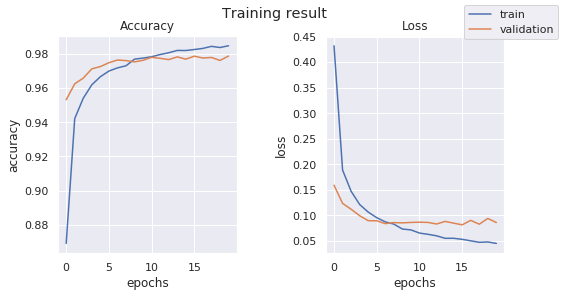

In [65]:
display_history(history = history)

In [66]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9793


In [0]:
from keras.layers import Activation, BatchNormalization
def create_mlp(layers, initializer):

  model = Sequential()
  model.add(Dense(HIDDENS, input_shape = (784,), kernel_initializer = initializer))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  if layers > 2:
    for i in range(layers - 2):
      model.add(Dense(HIDDENS, activation = 'relu',kernel_initializer=initializer))
  model.add(Dense(CLASSES, activation = 'softmax', kernel_initializer = initializer))
  return model

In [68]:
if model != None:
  K.clear_session()
model = create_mlp(4,'glorot_uniform')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 135,306
Trainable params: 135,050
Non-trainable params: 256
______________________________________________

In [69]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 3s - loss: 0.2874 - acc: 0.9138 - val_loss: 0.1422 - val_acc: 0.9579
Epoch 2/20
 - 2s - loss: 0.1059 - acc: 0.9675 - val_loss: 0.1088 - val_acc: 0.9671
Epoch 3/20
 - 2s - loss: 0.0692 - acc: 0.9785 - val_loss: 0.0953 - val_acc: 0.9729
Epoch 4/20
 - 3s - loss: 0.0520 - acc: 0.9838 - val_loss: 0.1093 - val_acc: 0.9668
Epoch 5/20
 - 3s - loss: 0.0405 - acc: 0.9869 - val_loss: 0.1142 - val_acc: 0.9690
Epoch 6/20
 - 3s - loss: 0.0321 - acc: 0.9898 - val_loss: 0.1079 - val_acc: 0.9720
Epoch 7/20
 - 3s - loss: 0.0260 - acc: 0.9910 - val_loss: 0.1017 - val_acc: 0.9734
Epoch 8/20
 - 3s - loss: 0.0275 - acc: 0.9908 - val_loss: 0.0991 - val_acc: 0.9746
Epoch 9/20
 - 3s - loss: 0.0206 - acc: 0.9931 - val_loss: 0.1205 - val_acc: 0.9692
Epoch 10/20
 - 3s - loss: 0.0177 - acc: 0.9941 - val_loss: 0.1199 - val_acc: 0.9728
Epoch 11/20
 - 3s - loss: 0.0203 - acc: 0.9928 - val_loss: 0.1207 - val_acc: 0.9724
Epoch 12/20
 - 2s - loss: 0.0165 - 

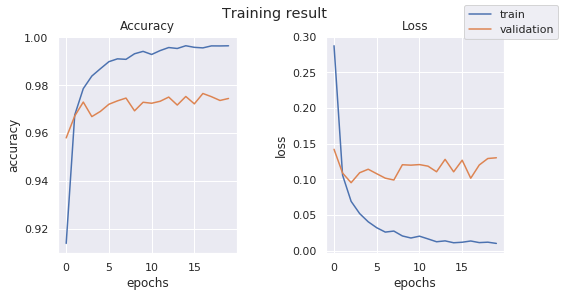

In [70]:
display_history(history = history)

In [71]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9773
